In [ ]:
%load_ext autoreload
%autoreload 2

In [1463]:
import tg
import tg.obj as obj
import tg.sampler as sampler
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [1464]:
dtype = tf.float64

In [1465]:
stone_color = tf.keras.utils.load_img("data/stone-color.jpg", color_mode="rgb")
stone_color = tf.keras.preprocessing.image.img_to_array(stone_color) / 255
stone_color = tf.transpose(tf.constant(stone_color, dtype=dtype), (1, 0, 2))

In [1466]:
stone_normal = tf.keras.utils.load_img("data/stone-normal.jpg", color_mode="rgb")
stone_normal = ((tf.keras.preprocessing.image.img_to_array(stone_normal) / 255) - 0.5) * 2
stone_normal = tf.transpose(tf.constant(stone_normal, dtype=dtype), (1, 0, 2))

In [1467]:
with open('data/susan.obj') as f:
    lines = f.readlines()

triangles, normals, uvs = obj.load(lines)

triangles = tf.constant(triangles, dtype=tf.float32)
normals = tf.constant(normals, dtype=tf.float32)
uvs = tf.constant(uvs, dtype=tf.float32)

triangles += (0, 0, 5)


In [1468]:
near_limit = 1
far_limit = 10
focal_length = 2000
width = 2000
height = 1000

In [1469]:
def perspective(triangles):
    scale = focal_length / triangles[...,2]
    x = triangles[...,0] * scale
    y = triangles[...,1] * scale
    z = triangles[...,2]
    return tf.stack([x + width/2, y + height/2, z], axis=-1)

def vertex_shader(triangles, uvs, normals):
    return triangles, uvs, normals

def pixel_shader(coordinates, uvs, normals):
    texture_color = sampler.sample_bilinear(stone_color, uvs)
    texture_normal = sampler.sample_bilinear(stone_normal, uvs) * 2
    
    cross_normal = tf.linalg.cross(normals, texture_normal)

    light_factor = tf.expand_dims(
        1 - (
            tf.sqrt(tf.reduce_sum(tf.square(cross_normal - (0, 0, -1)), -1)) / (12 ** 0.5)
        ),
        -1,
    ) - 0.5
    return texture_color + light_factor

In [1472]:
with tf.device("/CPU:0"):
    color = tg.render(triangles, (uvs, normals), width, height, near_limit, far_limit, perspective, vertex_shader, pixel_shader, dtype)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


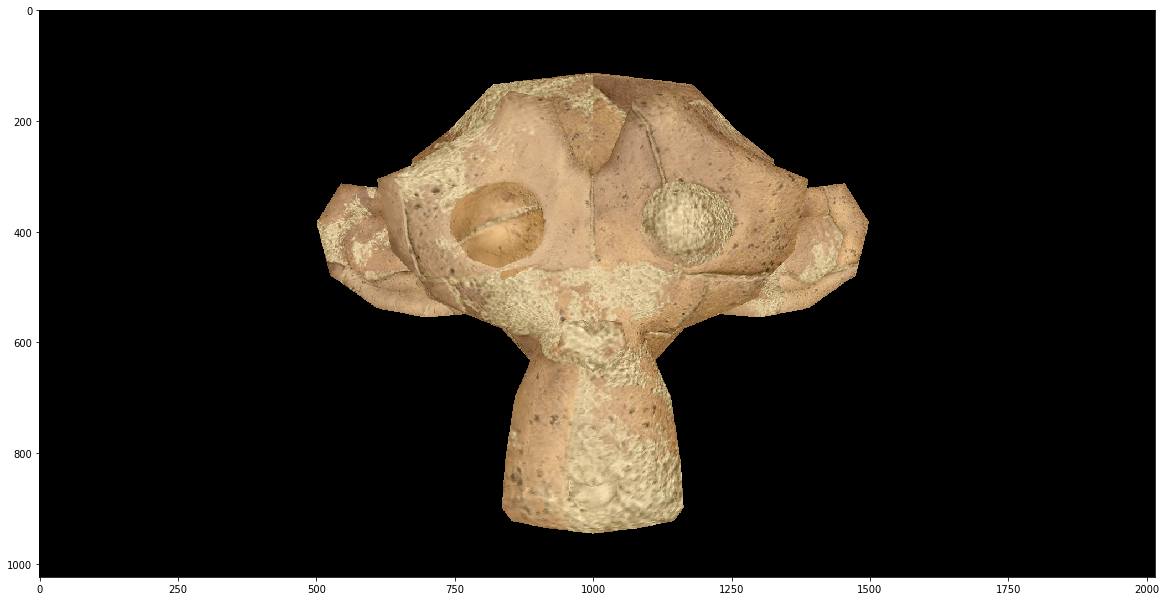

In [1473]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(
    # tf.transpose(depth),
    tf.transpose(tf.cast(color, tf.float32), (1, 0, 2)),
    interpolation='nearest'
)
pass